# US Stock Market
In this notebook I look at:
* the market capitalization of listed domestic companies in the US
* the market capitalization of listed domestic companies in the US as percentage of US GDP
* the total annual value of stocks traded on US exchanges 
* the total annual value of stocks traded on US exchanges as perccentage of US GDP

The only publically available source of these data is [The World Bank](https://data.worldbank.org). Unfortunately it only provides data at annual granularity rather than quarterly or monthly. All amounts are represented in either Billions of USD or as percentage points.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from pandas_datareader import wb

from datetime import date

In [2]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

In [3]:
stock_mkt = wb.download(indicator=['CM.MKT.LCAP.CD', 'CM.MKT.LCAP.GD.ZS', 'CM.MKT.TRAD.CD', 'CM.MKT.TRAD.GD.ZS',
                                   'CM.MKT.TRNR', 'CM.MKT.LDOM.NO'],
                        country='US', start=report_start, end=report_end).loc['United States'].dropna(how='all')
stock_mkt.index = pd.to_datetime(stock_mkt.index).shift(1, 'A')
stock_mkt = stock_mkt.asfreq('A')

# Convert into billions of USD
stock_mkt.loc[:, ['CM.MKT.LCAP.CD', 'CM.MKT.TRAD.CD']] /= 1e9

In [4]:
ts = pd.to_datetime('2023-12-31')
if stock_mkt.index[-1] < ts:
    # Small adjustment for not yet published data for US market capitalization at the end of 2023
    stock_mkt.loc[ts, 'CM.MKT.LCAP.CD'] = 50781.6975
    gdp = web.get_data_fred('GDPA', start=report_start, end=report_end)
    gdp.index = gdp.index.shift(1, 'A')
    gdp = gdp.asfreq('A')
    stock_mkt.loc[ts, 'CM.MKT.LCAP.GD.ZS'] = stock_mkt.loc[ts, 'CM.MKT.LCAP.CD'] / gdp.GDPA.loc[ts] * 100

In [5]:
# Human readable column names for DataFrames
MKT_CAP = 'Market capitalization of listed domestic companies'
MKT_CAP_TO_GDP = MKT_CAP + ' (% of GDP)'
MKT_CAP_GRAPH_TITLE = 'US ' + MKT_CAP
TRAD_VOL = 'Stocks traded, total value'
TRAD_VOL_TO_GDP = TRAD_VOL + ' (% of GDP)'
TRAD_VOL_GRAPH_TITLE = 'US ' + TRAD_VOL + ' (annual)'
TUROVER_RATIO = 'Stocks traded, turnover ratio of domestic shares (%)'
TUROVER_RATIO_GRAPH_TITLE = 'US ' + TUROVER_RATIO
NUM_LISTED_DOMESTIC = 'Number of listed domestic companies'
NUM_LISTED_DOMESTIC_GRAPH_TITLE = 'US Listed domestic companies, total'

In [6]:
stock_mkt.rename(
    columns={'CM.MKT.LCAP.CD': MKT_CAP, 'CM.MKT.LCAP.GD.ZS': MKT_CAP_TO_GDP,
             'CM.MKT.TRAD.CD': TRAD_VOL, 'CM.MKT.TRAD.GD.ZS': TRAD_VOL_TO_GDP,
             'CM.MKT.TRNR': TUROVER_RATIO, 'CM.MKT.LDOM.NO': NUM_LISTED_DOMESTIC},
    inplace=True)

In [7]:
pd.options.display.max_rows = 40
stock_mkt.iloc[:,:4]

,Market capitalization of listed domestic companies,Market capitalization of listed domestic companies (% of GDP),"Stocks traded, total value","Stocks traded, total value (% of GDP)"
year,,,,
1975-12-31,703.80000,41.770926,137.28100,8.147705
1976-12-31,883.10000,47.138590,173.32100,9.251622
1977-12-31,834.23800,40.072417,165.87400,7.967717
1978-12-31,861.96100,36.654251,225.84400,9.603848
1979-12-31,993.59090,37.817471,271.85090,10.347029
...,...,...,...,...
2019-12-31,34085.72737,159.420820,36342.31408,169.975000
2020-12-31,41569.86177,197.383319,41086.46143,195.088022
2021-12-31,48548.53812,208.228052,45874.14553,196.757397


For the S&P 500 index I will obtain data directly from Yahoo-Finance. For a current list of S&P 500 constituent companies, I use Wikipedia. The index actually contains 503 stocks since it includes two share classes of stock from 3 of its component companies.

In [8]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
sp500_components = df['Symbol'].to_list()

In [9]:
LEFT_Y_AXIS_LABEL = 'Billions of USD'
RIGHT_Y_AXIS_LABEL = '% of GDP'

## Market capitalization of listed domestic companies and its ratio to GDP
These measures allow to assess how overpriced the US stock market is. When the market capitalization in a given economy is more or less the same as the GDP, the market is considered fairly priced, higher capitalizations are deemed expensive. However, different markets have different norms of what is cheap or expensive when it comes to stock market capitalization to GDP ratios. The US stock market receives an extra premium thanks to its remarkable historical growth, high standards of corporate governanance, high volumes and liquidity.

**NB**: the market capitalzaion to GDP ratio only tells how cheap or expensive the overall stock market is. Even when the whole market is overpriced, it can contain adequately priced individual stocks.

Market capitalization values provided for a given year represent the weighted average capitalization of US listed domestic companies accross all trading days in that year. All dollar amounts are nominal, i.e. without adjustments for inflation.

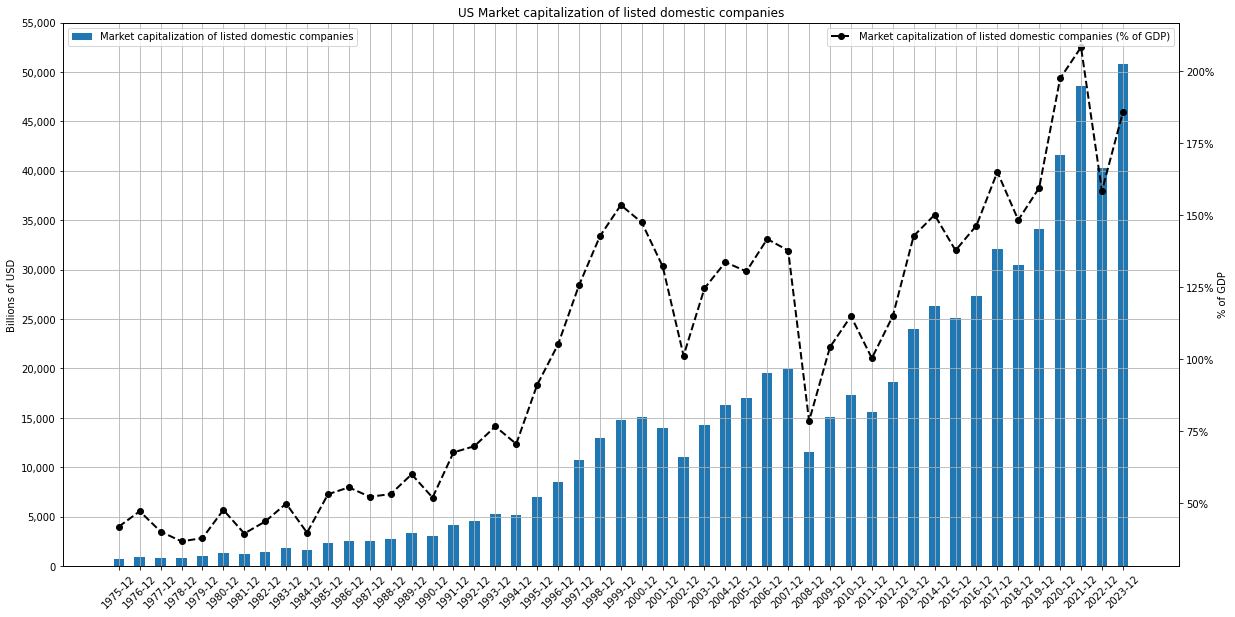

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
ax2 = ax.twinx()
ax.bar(x=range(len(stock_mkt)), height=stock_mkt.iloc[:,0], color='#1f77b4', width=0.5, label=MKT_CAP)
ax2.plot(range(len(stock_mkt)), stock_mkt.iloc[:,1], color='k', marker='o', label=MKT_CAP_TO_GDP,
         linestyle='--', linewidth=2)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.title.set_text(MKT_CAP_GRAPH_TITLE)
ax.grid(True)
_ = ax.set_xticks(range(len(stock_mkt)), stock_mkt.index)
_ = ax.set_xticklabels(stock_mkt.index.strftime('%Y-%m'), rotation=45)
ax.set_yticks(np.arange(0, 56000, 5000))
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax2.set_ylabel(RIGHT_Y_AXIS_LABEL)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

## Total annual value of stocks traded on US exchanges and its ratio to GDP
I this section of the notebook I look at the total volumes of domestic and foreign stocks traded on US exchanges in the whole year. If you want to approximate the daily trading volumes, please divide the annual value by 252, which is an approximation for the number of trading days in the US. All dollar amounts are nominal, i.e. without adjustments for inflation. I also plot the ratio of annual trading volumes to annual GDP.

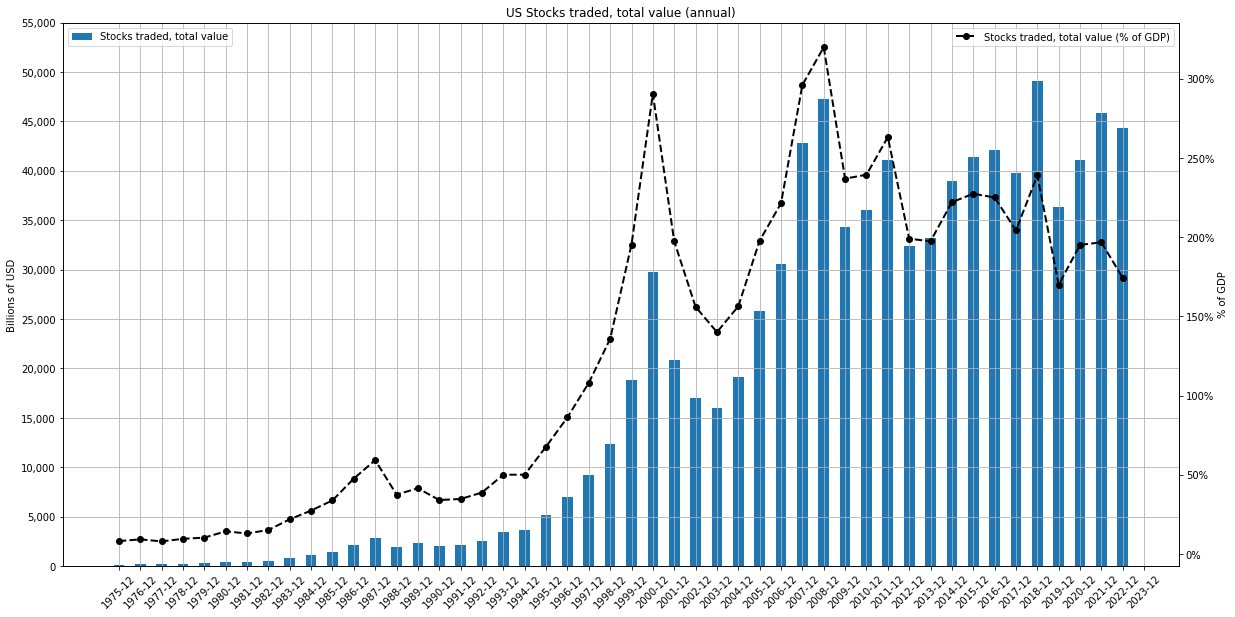

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
ax2 = ax.twinx()
ax.bar(x=range(len(stock_mkt)), height=stock_mkt.iloc[:,2], color='#1f77b4', width=0.5, label=TRAD_VOL)
ax2.plot(range(len(stock_mkt)), stock_mkt.iloc[:,3], color='k', marker='o', label=TRAD_VOL_TO_GDP,
         linestyle='--', linewidth=2)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.title.set_text(TRAD_VOL_GRAPH_TITLE)
ax.grid(True)
_ = ax.set_xticks(range(len(stock_mkt)), stock_mkt.index)
_ = ax.set_xticklabels(stock_mkt.index.strftime('%Y-%m'), rotation=45)
ax.set_yticks(np.arange(0, 56000, 5000))
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax2.set_ylabel(RIGHT_Y_AXIS_LABEL)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

## Stocks traded, turnover ratio of domestic shares to capitalization
In this section of the notebook I look at the turnover ratio of domestic shares traded divided by their market capitalization. The value is annualized by multiplying the monthly average by 12. Unfortunately the World Bank doesn't contain newer datum than 2017.

The graph depicts the total domestic value of share trading of American Stock Exchange, New York Stock Exchange, NASDAQ Stock Market and BATS Global Markets divided by the total domestic market capitalization of American Stock Exchange, New York Stock Exchange and NASDAQ Stock Market.

If you divide the number for a given year by 252 (the approximate number of trading days in the US), you obtain the percentage of domestic listed shares that are traded in one day. This ranges between 0.2% and 1.7%. And such small fraction of traded shares determine the capitalization of the whole firm.

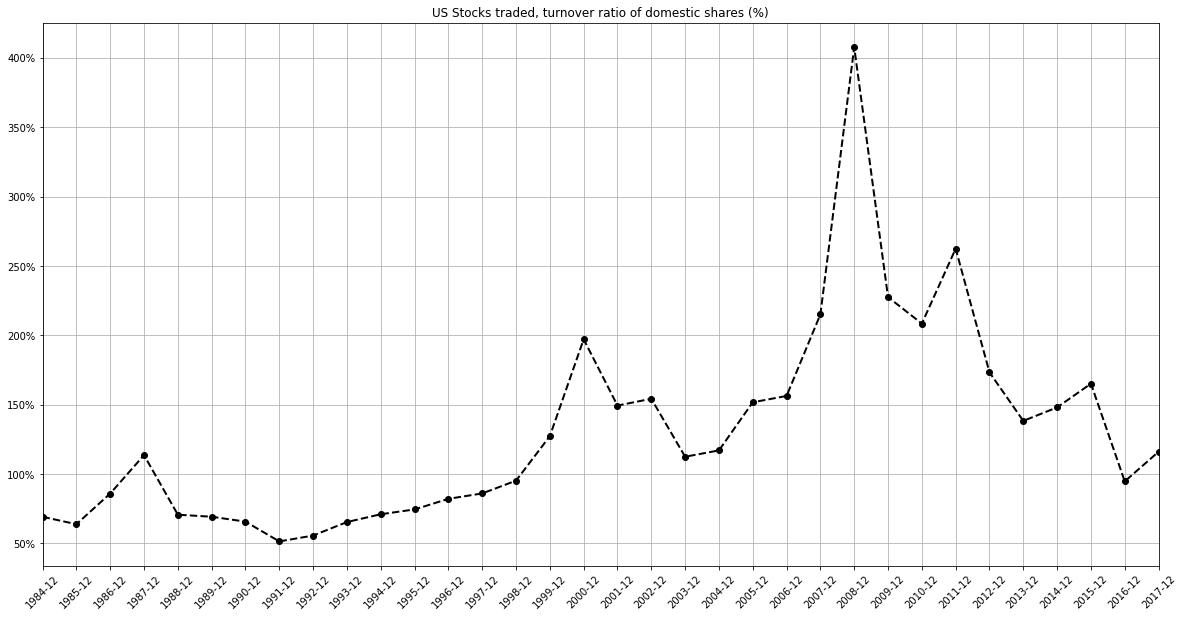

In [12]:
turnover_ratio = stock_mkt.iloc[:,4].dropna()
ax = turnover_ratio.dropna().plot(figsize=(20,10), grid=True,
                                  title=TUROVER_RATIO_GRAPH_TITLE, color='k', marker='o', linestyle='--', linewidth=2,
                                  xticks=turnover_ratio.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, turnover_ratio.index)))

In [13]:
print('Approximately between {:.2f}% and {:.2f}% of domestic shares are traded daily on US exchanges'.format(
    turnover_ratio.min() / 252, turnover_ratio.max() / 252))

Approximately between 0.20% and 1.62% of domestic shares are traded daily on US exchanges


## Total number of listed domestic companies
In this section of the notebook I look at the total number of listed domestic US companies, including foreign companies which are exclusively listed in the US. Counted are those companies which have shares listed on a US exchange at the end of the year. Investment funds, unit trusts, and companies whose only business goal is to hold shares of other listed companies, such as holding companies and investment companies, regardless of their legal status, are excluded. A company with several classes of shares is counted once. Only companies admitted to listing on US exchanges are included.

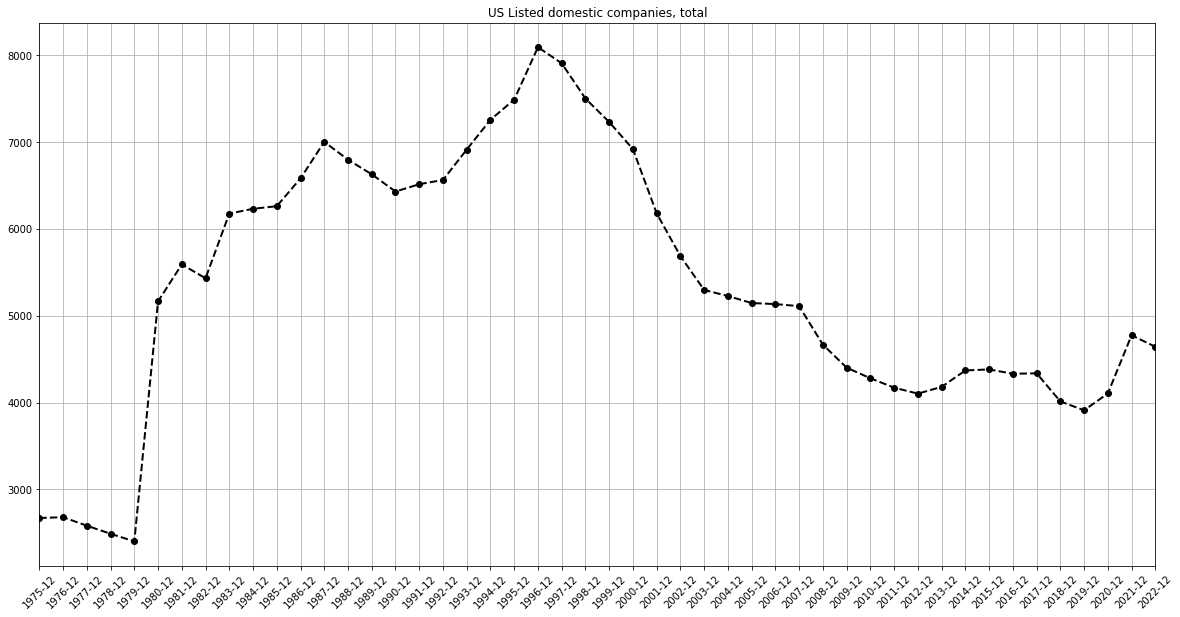

In [14]:
num_domestic_listed = stock_mkt.iloc[:,5].dropna()
ax = num_domestic_listed.dropna().plot(figsize=(20,10), grid=True,
                                       title=NUM_LISTED_DOMESTIC_GRAPH_TITLE, color='k', marker='o', linestyle='--',
                                        linewidth=2, xticks=num_domestic_listed.index, xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, num_domestic_listed.index)))